# Rental Location EDA
## *** Steps
#### 0) Data load & preprocess
#### 1) Data overview
#### 2) Variables relations 
        -2-1) Variable scatter plots
        -2-2) Geo data visualization
#### 3) Clustering 
#### 4) Oberservation

In [72]:
# load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import matplotlib.pyplot as plt
import folium
from folium import plugins
from mpl_toolkits.basemap import Basemap
import reverse_geocode 


# set plot style
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

Populating the interactive namespace from numpy and matplotlib


/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## 0) Data load & preprocess

In [3]:
# help func

# -----------------------
# feature engineering 

def get_haversine_distance(lat1, lng1, lat2, lng2):
    # km
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  #  km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


def get_manhattan_distance(lat1, lng1, lat2, lng2):
    # km 
    a = get_haversine_distance(lat1, lng1, lat1, lng2)
    b = get_haversine_distance(lat1, lng1, lat2, lng1)
    return a + b




def plot_heatmap_lon_lat(df,lat,lon,map_center):
    #map_center = [50.87650,4.39723]
    print (map_center)
    heatmap = folium.Map(location=map_center, 
                         tiles='https://api.tiles.mapbox.com/v4/mapbox.light/{z}/{x}/{y}.png?access_token=pk.eyJ1IjoiZ29nb3ZhbmFwcCIsImEiOiJjaWg3MTk0ZjAwZmI5dXVraTF5aDNudTd0In0.mcuRTlI-EWoMm0IponVnVA',
                         attr='Map data &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors, <a href="http://creativecommons.org/licenses/by-sa/2.0/">CC-BY-SA</a>, Imagery © <a href="http://mapbox.com">Mapbox</a>',
                         zoom_start=11)

    # plz modify lon / lat columns here in cases for various dataset 
    heatmap_locations_list = df[[lat, lon]].dropna().values.tolist()
    heatmap.add_children(plugins.HeatMap(heatmap_locations_list, radius=20, blur=30))
    display(heatmap)

    
def get_country_lon_lat(lon,lat):
    pass
    
# -----------------------


In [82]:
df=pd.read_csv('DemoLondonRentals.csv')
df.columns=['id','borrower_lat','borrower_lng','lender_lat','lender_lng']

In [83]:
# get distance 
df.loc[:, 'distance_manhattan'] = get_manhattan_distance(
                                  df['borrower_lat'].values,
                                  df['borrower_lng'].values,
                                  df['lender_lat'].values,
                                  df['lender_lng'].values)

df.loc[:, 'distance_haversine'] = get_haversine_distance(
                                  df['borrower_lat'].values,
                                  df['borrower_lng'].values,
                                  df['lender_lat'].values,
                                  df['lender_lng'].values)


# get borrower country 
coordinates=[i for i in list(zip( df.borrower_lat, df.borrower_lng))]
revere_results=reverse_geocode.search(coordinates)
country_list=[m['country'] for m in revere_results]
city_list=[m['city'] for m in revere_results]
df['borrower_country'] = country_list
df['borrower_city'] = city_list
# get lender country 
coordinates2=[i for i in list(zip( df.lender_lat, df.lender_lng))]
revere_results2=reverse_geocode.search(coordinates2)
country_list2=[m['country'] for m in revere_results2]
city_list2=[m['city'] for m in revere_results2]
df['lender_country'] = country_list2
df['lender_city'] = city_list2


## 1) Data overview

In [88]:
df.head(3)

,id,borrower_lat,borrower_lng,lender_lat,lender_lng,distance_manhattan,distance_haversine,borrower_country,borrower_city,lender_country,lender_city
0,1,51.370,-0.0250,51.524,-0.3180,37.463402,26.561818,United Kingdom,West Wickham,United Kingdom,Wembley
1,2,51.397,-0.1160,51.421,-0.1770,6.900663,5.002213,United Kingdom,South Croydon,United Kingdom,Mitcham
2,3,51.515,0.0193,51.493,0.0602,5.276474,3.741409,United Kingdom,Poplar,United Kingdom,Barking


(-1, 50)

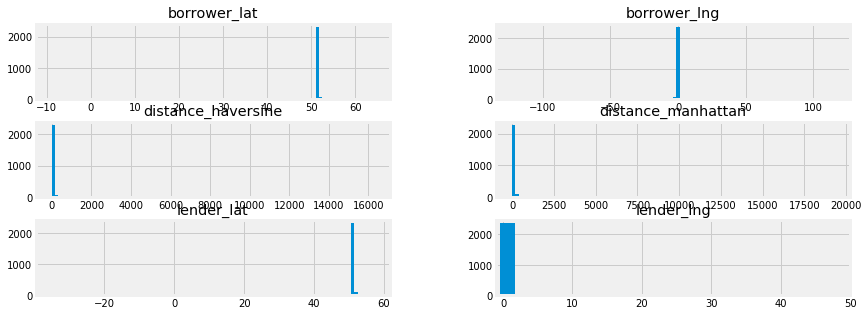

In [6]:
# hist of all cols 
df.iloc[:,1:].hist(bins=100,figsize=(13,5))
plt.xlim(-1,50)

Text(0.5,0,'distance_manhattan')

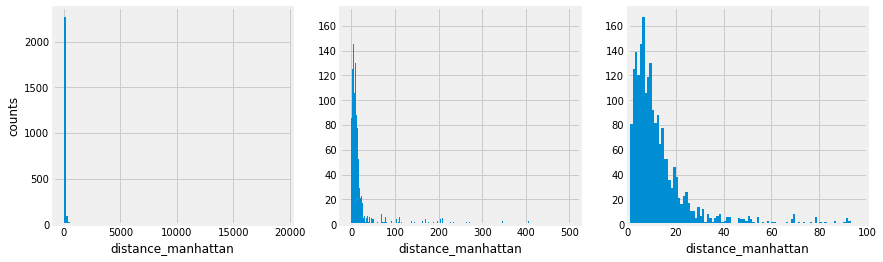

In [7]:
# distance histgram (distance_manhattan)



# make sure the ranges we chose are sensible
fig, axArray = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
# hist for all range 
axArray[0].hist(df['distance_manhattan'],100); 
axArray[0].set_xlabel('distance_manhattan')
axArray[0].set_ylabel('counts')
# hist form 0 - 500
axArray[1].hist(df['distance_manhattan'] ,bins=range(0, 500))
plt.xlim(0,500)
axArray[1].set_xlabel('distance_manhattan')
# hist from 0 - 100 
axArray[2].hist(df['distance_manhattan'],bins=range(0, 100))
plt.xlim(0,100)
axArray[2].set_xlabel('distance_manhattan')



In [118]:
# borrower_country VS lender_country

top_country= df.borrower_country.value_counts().head(20).index

df_country=df[(df.borrower_country.isin(top_country)) &
              (df.lender_country.isin(top_country))]
b_l_country_count= df_country.groupby(['borrower_country','lender_country']).count()['id'].reset_index()
country_count_pivot=  pd.pivot_table(b_l_country_count,columns=['borrower_country'],index=['lender_country']).fillna(0)
country_count_pivot

id                                                   \
borrower_country Cyprus Dominican Republic France Germany Greece Hungary   
lender_country                                                             
Cyprus              0.0                0.0    0.0     0.0    0.0     0.0   
France              0.0                0.0    0.0     0.0    0.0     0.0   
Germany             0.0                0.0    0.0     0.0    0.0     0.0   
India               0.0                0.0    0.0     0.0    0.0     0.0   
Turkey              0.0                0.0    0.0     0.0    0.0     0.0   
United Kingdom      2.0                9.0    2.0     9.0    2.0     1.0   
United States       0.0                0.0    0.0     0.0    0.0     0.0   

                                                                           \
borrower_country Iceland India Indonesia Italy Latvia Lebanon Netherlands   
lender_country                                                              
Cyprus               0.0   0.0       0.0   0.0    0.0     0.0         0.0   
France               0.0   0.0       0.0   0.0    0.0     0.0         0.0   
Germany              0.0   0.0       0.0   0.0    0.0     0.0         0.0   
India                0.0   0.0       0.0   0.0    0.0     0.0         0.0   
Turkey               0.0   0.0       0.0   0.0    0.0     0.0         0.0   
United Kingdom       3.0   1.0       3.0   4.0    1.0     7.0         3.0   
United States        0.0   0.0       0.0   0.0    0.0     0.0         0.0   

                                                                           \
borrower_country Nigeria Spain Turkey United Arab Emirates United Kingdom   
lender_country                                                              
Cyprus               0.0   0.0    0.0                  0.0            2.0   
France               0.0   0.0    0.0                  0.0           16.0   
Germany              0.0   0.0    0.0                  0.0            2.0   
India                0.0   0.0    0.0                  0.0            1.0   
Turkey               0.0   0.0    0.0                  0.0            1.0   
United Kingdom       2.0   4.0    2.0                  1.0         2377.0   
United States        0.0   0.0    0.0                  0.0           13.0   

                                
borrower_country United States  
lender_country                  
Cyprus                     0.0  
France                     0.0  
Germany                    0.0  
India                      0.0  
Turkey                     0.0  
United Kingdom             6.0  
United States              0.0

## 2 Variables relations 

### 2-1) Variable scatter plots


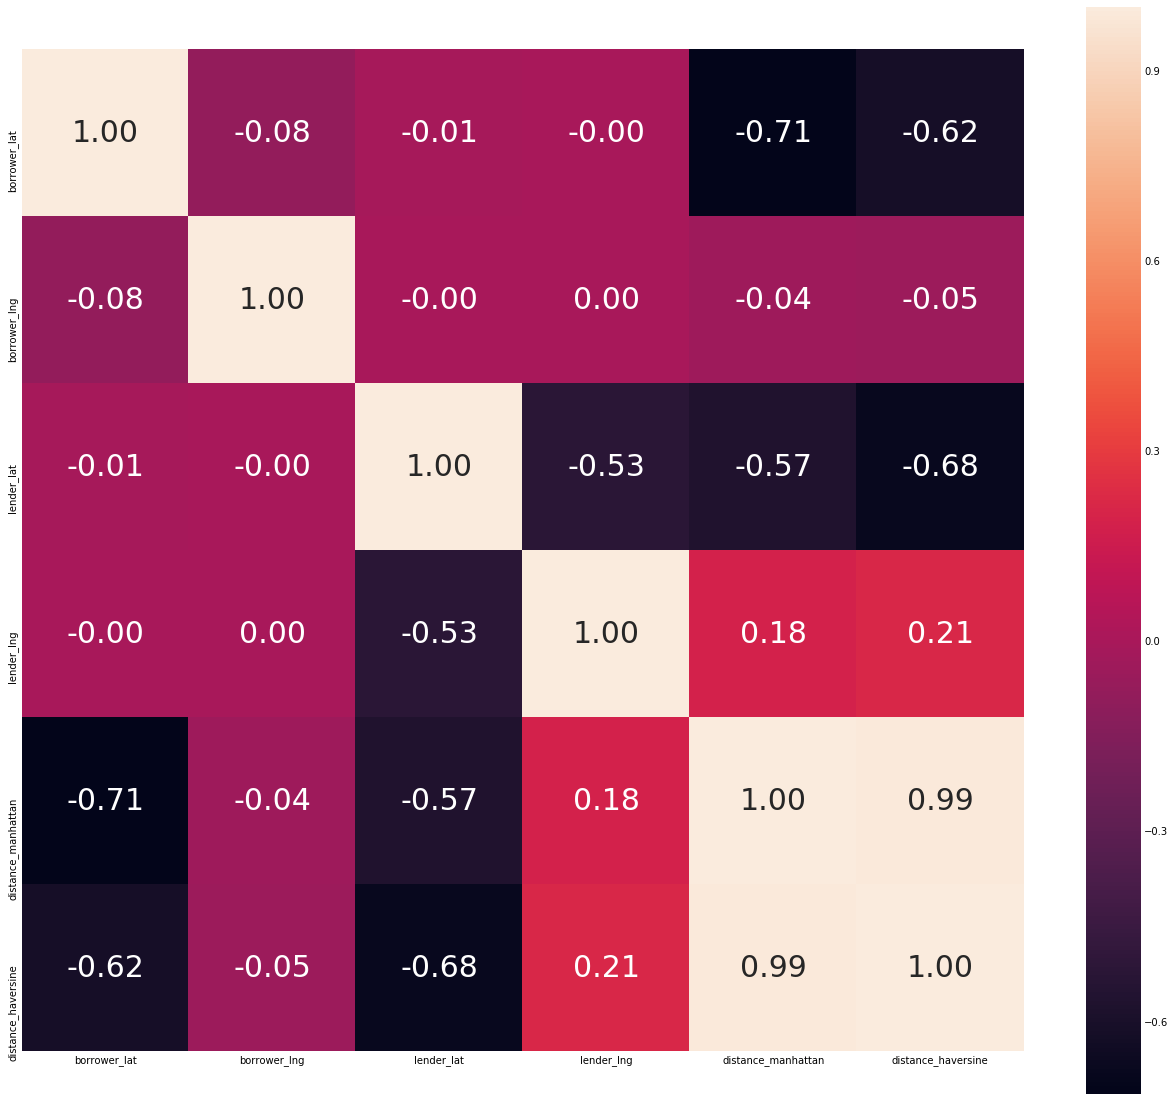

In [8]:
# heat map of correlation within cols 


cm = np.corrcoef(df.iloc[:,1:].values.T)
cols = df.iloc[:,1:].columns

# df.iloc[:,1:].corr()
plt.figure(figsize=(20,20))
#sns.set(font_scale=5)
hm = sns.heatmap( cm, 
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                annot_kws={'size':30},
                yticklabels=cols,
                xticklabels=cols, 
            
                )
plt.show()

/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


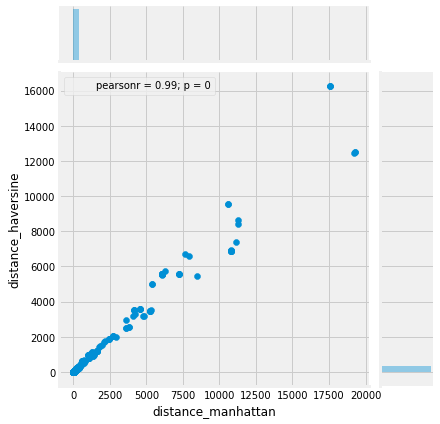

In [9]:
# manhattan VS haversine distance

sns.jointplot(x="distance_manhattan", y="distance_haversine",data=df)

### 2-2) Geo data visualization

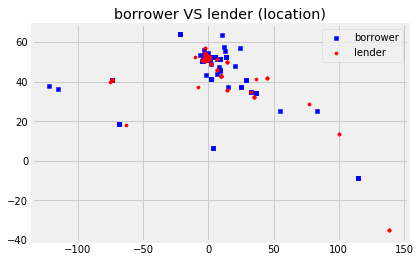

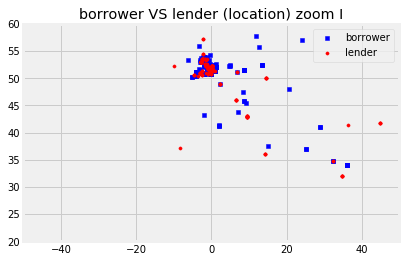

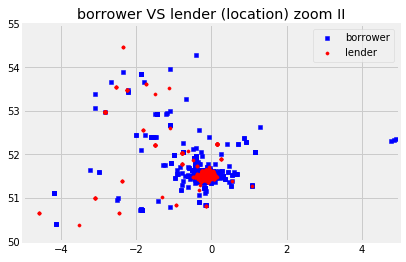

In [17]:
# visualize borrower & lender 


fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.array(df.borrower_lng), np.array(df.borrower_lat), s=10, c='b', marker="s", label='first')
ax1.scatter(np.array(df.lender_lng), np.array(df.lender_lat), s=10, c='r', marker="o", label='second')
plt.legend(['borrower','lender'])
plt.title('borrower VS lender (location)')
plt.show()



fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.array(df.borrower_lng), np.array(df.borrower_lat), s=10, c='b', marker="s", label='first')
ax1.scatter(np.array(df.lender_lng), np.array(df.lender_lat), s=10, c='r', marker="o", label='second')
plt.xlim(-50,50)
plt.ylim(20,60)
plt.legend(['borrower','lender'])
plt.title('borrower VS lender (location) zoom I')
plt.show()




fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(np.array(df.borrower_lng), np.array(df.borrower_lat), s=10, c='b', marker="s", label='first')
ax1.scatter(np.array(df.lender_lng), np.array(df.lender_lat), s=10, c='r', marker="o", label='second')
plt.xlim(-5,5)
plt.ylim(50,55)
plt.legend(['borrower','lender'])
plt.title('borrower VS lender (location) zoom II')
plt.show()

In [10]:
# borrower heatmap 
plot_heatmap_lon_lat(df,'borrower_lat','borrower_lng',[51.370,-0.025])

[51.37, -0.025]


/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/ipykernel/__main__.py:36: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [11]:
# lender heatmap 
plot_heatmap_lon_lat(df,'lender_lat','lender_lng',[51.524,-0.3180])

[51.524, -0.318]


/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/site-packages/ipykernel/__main__.py:36: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


In [13]:
#http://www.bigendiandata.com/2017-06-27-Mapping_in_Jupyter/



In [26]:
########